In [1]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
import random

from fastmri.models import Unet
from fastmri.data.subsample import create_mask_for_mask_type 
from fastmri.data.transforms import to_tensor, center_crop, apply_mask, normalize, normalize_instance
from fastmri import ifft2c, complex_abs, rss
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

/home/yusuf/miniconda3/envs/fastmri_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class fastmri_dataset(Dataset):
    def __init__(self, data_dir, data_list, mask_type, center_fractions, accelerations, crop_size=(320,320), transform=None):
        self.data_dir = data_dir
        self.file_paths = [os.path.join(data_dir, fname) for fname in data_list if fname.endswith('.h5')]
        self.transform = transform
        self.mask_type = mask_type
        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.crop_size = crop_size
        self.slice_info = []

        # Pre-compute mask function to avoid recreation in __getitem__
        self.mask_func = create_mask_for_mask_type(
        mask_type_str=self.mask_type,
        center_fractions=self.center_fractions,
        accelerations=self.accelerations
)

        # Precompute slice indexing to avoid iterating over files at every __getitem__
        for file_idx, file_path in enumerate(self.file_paths):
            with h5py.File(file_path, 'r') as f:
                num_slices = f['kspace'].shape[0]
                self.slice_info.extend([(file_idx, slice_idx) for slice_idx in range(num_slices)])


    def __len__(self):
        return len(self.slice_info)


    def __getitem__(self, idx):
        file_idx, slice_idx = self.slice_info[idx]
        file_path = self.file_paths[file_idx]
        
        with h5py.File(file_path, 'r') as f:
            kspace = to_tensor(f['kspace'][slice_idx])
            target = to_tensor(f['reconstruction_rss'][slice_idx])

            masked_kspace, mask, _ = apply_mask(kspace.unsqueeze(0), self.mask_func)
            masked_kspace = masked_kspace.squeeze(0)

            undersampled_image = complex_abs(ifft2c(masked_kspace))
            undersampled_image_cropped = center_crop(undersampled_image, self.crop_size)
            undersampled_image_rss = rss(undersampled_image_cropped, dim=0)

            # normalize input
            undersampled_image_rss, mean, std = normalize_instance(undersampled_image_rss, eps=1e-11)
            undersampled_image_rss = undersampled_image_rss.clamp(-6, 6)

            # normalize target
            if target is not None:
                target = center_crop(target, self.crop_size)
                target = normalize(target, mean, std, eps=1e-11)
                target = target.clamp(-6, 6)


        if self.transform:
            undersampled_image_rss, target = self.transform(undersampled_image_rss, target)

        return undersampled_image_rss.float(), target.float()


In [3]:
#from unet import SimpleUnet
#model = SimpleUnet(in_channels=1, out_channels=1, chans=64).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_chans=1, out_chans=1, chans=128, num_pool_layers=4).to(device)
model = nn.DataParallel(model).to(device)

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001, save_path="checkpoints"):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float("inf") #instead of None
        self.counter = 0
        self.early_stop = False

        os.makedirs(save_path, exist_ok=True)

    def __call__(self, val_loss, epoch, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save({
                "model_state_dict": model.state_dict()
            }, os.path.join(self.save_path,f"epoch={epoch}_valloss={self.best_loss}.pt"))
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [5]:
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)

def compute_metrics(outputs, targets):
    drange=np.max(targets)-np.min(targets)
    psnr_value = psnr(outputs, targets,data_range=drange).item()
    ssim_value = ssim(outputs, targets,data_range=drange).item()
    return psnr_value, ssim_value


/home/yusuf/miniconda3/envs/fastmri_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs, device):

    scaler = GradScaler()
    writer = SummaryWriter(log_dir="./logs")
    early_stopping = EarlyStopping()
    best_metrics = {"psnr":0, "ssim":0}


    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0

        torch.cuda.empty_cache()

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            #ensuring inputs and targets are properly distributed across both gpus
            inputs, targets = inputs.unsqueeze(1).to(device, non_blocking=True), targets.unsqueeze(1).to(device, non_blocking=True)

            with autocast():  # Mixed precision training
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            # delete unnecessary tensors
            del outputs
            del loss

        avg_train_loss = train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_metrics = {'loss': 0, 'psnr': 0, 'ssim': 0}
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"\t - Validation"):
                inputs, targets = inputs.unsqueeze(1).to(device), targets.unsqueeze(1).to(device)
                outputs = model(inputs)

                val_metrics['loss'] += loss_fn(outputs, targets).item()
                val_metrics['psnr'] += psnr(outputs, targets).item()
                val_metrics['ssim'] += ssim(outputs, targets).item()

                # delete unnecessary tensors
                del outputs

        # Average metrics
        for key in val_metrics:
            val_metrics[key] /= len(val_loader)

        scheduler.step(val_metrics['loss'])

        # Log losses
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_metrics['loss'], epoch)
        writer.add_scalar("Metrics/PSNR", val_metrics['psnr'], epoch)
        writer.add_scalar("Metrics/SSIM", val_metrics['ssim'], epoch)

        # Update best metrics
        if val_metrics['psnr'] > best_metrics['psnr']:
            best_metrics['psnr'] = val_metrics['psnr']
        if val_metrics['ssim'] > best_metrics['ssim']:
            best_metrics['ssim'] = val_metrics['ssim']

        print(f"\t  - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}, Val PSNR: {val_metrics['psnr']:.4f}, Val SSIM: {val_metrics['ssim']:.4f}")

        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} memory allocated: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        
        # Early stopping
        early_stopping(val_metrics['loss'], epoch+1, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()

    writer.close()
    return best_metrics


In [7]:
config = {
    'data_dir': "/home/yusuf/Desktop/projects/data/fastmri/multicoil_train",
    'mask_type': "equispaced",
    'center_fractions': [0.08],
    'accelerations': [4],
    'batch_size' : 4,      #2
    'epochs' : 10,
    'lr' : 1e-3,
    'num_workers': 4
}

train_csv = pd.read_csv('train_file_lists/train_files_AXT1POST.csv')
data_list = train_csv.file_name.to_list()[:200]
train_files, val_files = train_test_split(data_list, test_size=0.1, random_state=42)

# Dataset and DataLoaders
train_dataset = fastmri_dataset(config['data_dir'], train_files, config['mask_type'], config['center_fractions'], config['accelerations'])
val_dataset = fastmri_dataset(config['data_dir'], val_files, config['mask_type'], config['center_fractions'], config['accelerations'])

train_loader = DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'],
    pin_memory=True
    )
val_loader = DataLoader(
    val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'],
    pin_memory=True
    )


In [7]:
# Loss Function and Optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

NameError: name 'config' is not defined

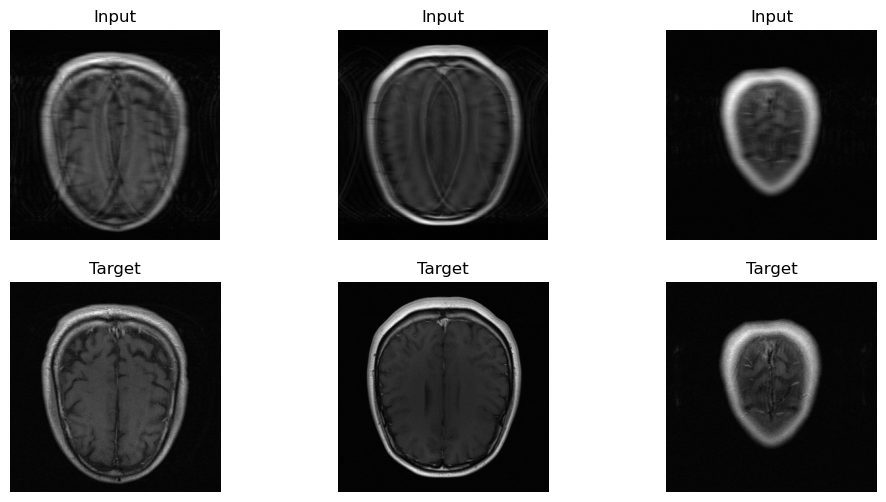

In [9]:
#sanity check

for inputs, targets in train_loader:
    # Ensure batch size is at least as large as num_samples
    batch_size = inputs.shape[0]
    num_samples = min(batch_size,3)

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        # Plot input image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(inputs[i].squeeze().numpy(), cmap='gray')
        plt.title("Input")
        plt.axis("off")

        # Plot target image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(targets[i].squeeze().numpy(), cmap='gray')
        plt.title("Target")
        plt.axis("off")

    plt.show()
    break

In [10]:
best_metrics = train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, config['epochs'], device)

Epoch 1/10 - Training:   0%|          | 0/710 [00:07<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 576.00 MiB (GPU 0; 10.57 GiB total capacity; 8.25 GiB already allocated; 560.75 MiB free; 9.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
best_metrics

{'psnr': 31.643155375613443, 'ssim': 0.8559630505646332}

In [12]:
cont_best_metrics = train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, config['epochs'], device)

	 - Validation: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


	  - Train Loss: 0.0270, Val Loss: 0.0453, Val PSNR: 34.7116, Val SSIM: 0.8982
GPU 0 memory allocated: 5.61 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:49<00:00,  1.61it/s]


	  - Train Loss: 0.0272, Val Loss: 0.0417, Val PSNR: 34.5455, Val SSIM: 0.8998
GPU 0 memory allocated: 5.88 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:48<00:00,  1.62it/s]


	  - Train Loss: 0.0285, Val Loss: 0.0583, Val PSNR: 33.5822, Val SSIM: 0.8830
GPU 0 memory allocated: 6.14 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:51<00:00,  1.52it/s]


	  - Train Loss: 0.0264, Val Loss: 0.0528, Val PSNR: 34.7899, Val SSIM: 0.8986
GPU 0 memory allocated: 6.40 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [01:05<00:00,  1.20it/s]


	  - Train Loss: 0.0257, Val Loss: 0.0471, Val PSNR: 33.8846, Val SSIM: 0.8966
GPU 0 memory allocated: 6.66 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


	  - Train Loss: 0.0267, Val Loss: 0.0438, Val PSNR: 33.6199, Val SSIM: 0.8878
GPU 0 memory allocated: 6.92 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:52<00:00,  1.49it/s]


	  - Train Loss: 0.0258, Val Loss: 0.0467, Val PSNR: 35.0057, Val SSIM: 0.8995
GPU 0 memory allocated: 7.18 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


	  - Train Loss: 0.0253, Val Loss: 0.0373, Val PSNR: 35.0931, Val SSIM: 0.9059
GPU 0 memory allocated: 7.44 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:52<00:00,  1.49it/s]


	  - Train Loss: 0.0256, Val Loss: 0.0421, Val PSNR: 34.8092, Val SSIM: 0.9014
GPU 0 memory allocated: 7.70 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [01:06<00:00,  1.19it/s]


	  - Train Loss: 0.0258, Val Loss: 0.0368, Val PSNR: 35.1394, Val SSIM: 0.9054
GPU 0 memory allocated: 7.96 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:50<00:00,  1.55it/s]


	  - Train Loss: 0.0256, Val Loss: 0.0416, Val PSNR: 35.0224, Val SSIM: 0.9041
GPU 0 memory allocated: 8.22 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:54<00:00,  1.44it/s]


	  - Train Loss: 0.0249, Val Loss: 0.0393, Val PSNR: 35.0531, Val SSIM: 0.9054
GPU 0 memory allocated: 8.48 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s]


	  - Train Loss: 0.0248, Val Loss: 0.0390, Val PSNR: 34.9559, Val SSIM: 0.8976
GPU 0 memory allocated: 8.74 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [00:49<00:00,  1.58it/s]


	  - Train Loss: 0.0234, Val Loss: 0.0403, Val PSNR: 35.0331, Val SSIM: 0.9014
GPU 0 memory allocated: 9.00 GB
GPU 1 memory allocated: 0.00 GB


	 - Validation: 100%|██████████| 79/79 [01:40<00:00,  1.27s/it]


	  - Train Loss: 0.0251, Val Loss: 0.0384, Val PSNR: 35.0440, Val SSIM: 0.9033
GPU 0 memory allocated: 9.27 GB
GPU 1 memory allocated: 0.00 GB


In [13]:
torch.save({"model_state_dict": model.state_dict()}, ("checkpoints/epoch=35_last.pt"))

In [12]:
# load saved model

checkpoint=torch.load("checkpoints/fold=4_chans=128/epoch=17_valloss=0.03313745877740881.pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [13]:
def inference(model, test_loader, device, output_dir="reconstructions", visualize=False):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for i, (inputs, _) in enumerate(test_loader):  # Targets are optional during inference
            inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
            outputs = model(inputs)

            # Post-process outputs (remove channel dim, convert to numpy)
            reconstructions = outputs.squeeze(1).cpu().numpy()

            # Save reconstructions
            for j, recon in enumerate(reconstructions):
                idx = i * len(reconstructions) + j
                output_path = os.path.join(output_dir, f"recon_{idx}.npy")
                np.save(output_path, recon)

                # Optional: Visualize the reconstruction
                if visualize:
                    plt.figure(figsize=(6, 6))
                    plt.imshow(recon, cmap="gray")
                    plt.title(f"Reconstruction {idx}")
                    plt.axis("off")
                    plt.show()
    print(f"Reconstructions saved to {output_dir}")


In [15]:
test_config = {
    'data_dir': "/home/yusuf/Desktop/projects/data/fastmri/multicoil_val",
    'mask_type': "equispaced",
    'center_fractions': [0.08],
    'accelerations': [4],
    'batch_size' : 1,      #2
    'epochs' : 15,
    'lr' : 1e-3,
    'num_workers': 4
}

test_files = os.listdir(test_config['data_dir'])[:10]
test_dataset = fastmri_dataset(test_config['data_dir'], test_files, test_config['mask_type'], test_config['center_fractions'], test_config['accelerations'])
test_loader = DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False)

In [10]:
def run_inference(model, test_loader, device, output_dir="reconstructions"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    ssim_scores = []
    psnr_scores = []

    ssim.reset()
    psnr.reset()

    with torch.no_grad():
        for i, (input, target) in enumerate(tqdm(test_loader, desc="Processing test data")):
            input = input.unsqueeze(1).to(device)
            target = target.unsqueeze(1).to(device)
            output = model(input)

            ssim_score = ssim(output, target).cpu().item()
            psnr_score = psnr(output, target).cpu().item()

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)


    mean_ssim = np.mean(ssim_scores)
    std_ssim = np.std(ssim_scores)
    mean_psnr = np.mean(psnr_scores)
    std_psnr = np.std(psnr_scores)
    
    metrics_df = pd.DataFrame({
        'ssim': ssim_scores,
        'psnr': psnr_scores
    })
    
    # Save summary statistics
    summary_df = pd.DataFrame({
        'metric': ['SSIM', 'PSNR'],
        'mean': [mean_ssim, mean_psnr],
        'std': [std_ssim, std_psnr]
    })
    
    # Print results
    print(f"SSIM: Mean = {mean_ssim:.4f}, Std = {std_ssim:.4f}")
    print(f"PSNR: Mean = {mean_psnr:.4f}, Std = {std_psnr:.4f}")
    
    return metrics_df, summary_df

In [28]:
# 4 fold
metdf, sumdf = run_inference(model, test_loader, device)

Processing test data: 100%|██████████| 160/160 [00:07<00:00, 21.29it/s]

SSIM: Mean = 0.7842, Std = 0.1943
PSNR: Mean = 31.1253, Std = 4.2664


In [17]:
# 8 fold
metdf, sumdf = run_inference(model, test_loader, device)

Processing test data:   0%|          | 0/160 [00:00<?, ?it/s]

Processing test data: 100%|██████████| 160/160 [00:23<00:00,  6.80it/s]

SSIM: Mean = 0.7747, Std = 0.1855
PSNR: Mean = 28.9363, Std = 3.7253


In [11]:
# 4 fold 20 epochs 128 chans
metdf, sumdf = run_inference(model, test_loader, device)

Processing test data: 100%|██████████| 160/160 [00:33<00:00,  4.82it/s]

SSIM: Mean = 0.7849, Std = 0.1710
PSNR: Mean = 30.6861, Std = 4.1817


In [14]:
# 8 fold 10 epochs 128 chans
metdf, sumdf = run_inference(model, test_loader, device)

Processing test data: 100%|██████████| 160/160 [00:38<00:00,  4.11it/s]

SSIM: Mean = 0.7068, Std = 0.2171
PSNR: Mean = 28.1365, Std = 4.0998


In [29]:
def run_inference_ZF(test_loader):

    ssim_scores = []
    psnr_scores = []

    ssim.reset()
    psnr.reset()

    with torch.no_grad():
        for i, (input, target) in enumerate(tqdm(test_loader, desc="Processing test data")):
            input = input.unsqueeze(1)
            target = target.unsqueeze(1)

            ssim_score = ssim(input, target).cpu().item()
            psnr_score = psnr(input, target).cpu().item()

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)


    mean_ssim = np.mean(ssim_scores)
    std_ssim = np.std(ssim_scores)
    mean_psnr = np.mean(psnr_scores)
    std_psnr = np.std(psnr_scores)
    
    metrics_df = pd.DataFrame({
        'ssim': ssim_scores,
        'psnr': psnr_scores
    })
    
    # Save summary statistics
    summary_df = pd.DataFrame({
        'metric': ['SSIM', 'PSNR'],
        'mean': [mean_ssim, mean_psnr],
        'std': [std_ssim, std_psnr]
    })
    
    # Print results
    print(f"SSIM: Mean = {mean_ssim:.4f}, Std = {std_ssim:.4f}")
    print(f"PSNR: Mean = {mean_psnr:.4f}, Std = {std_psnr:.4f}")
    
    return metrics_df, summary_df

In [30]:
zf_metdf, zf_sumdf = run_inference_ZF(test_loader)

Processing test data: 100%|██████████| 160/160 [00:06<00:00, 25.22it/s]

SSIM: Mean = 0.6271, Std = 0.2347
PSNR: Mean = 25.1485, Std = 3.7153


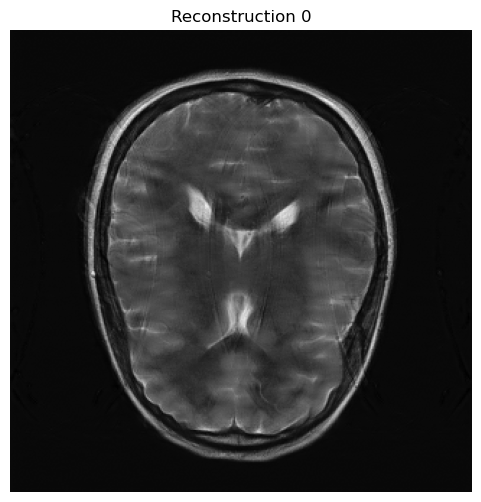

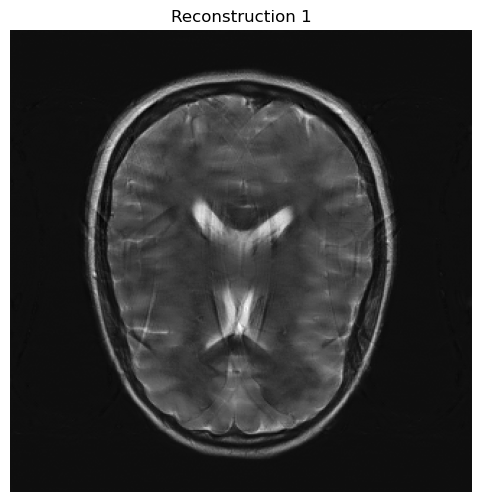

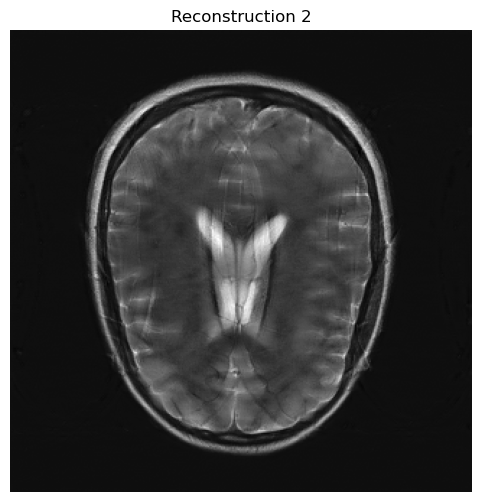

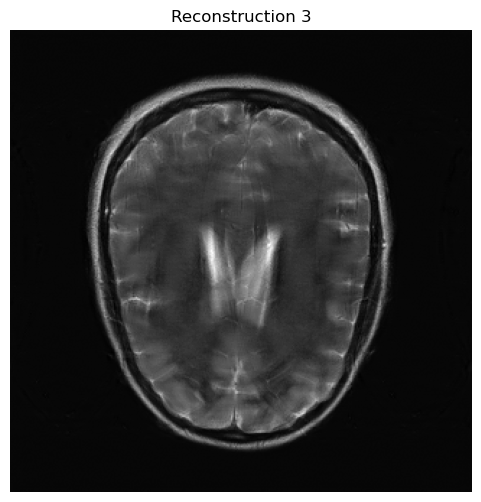

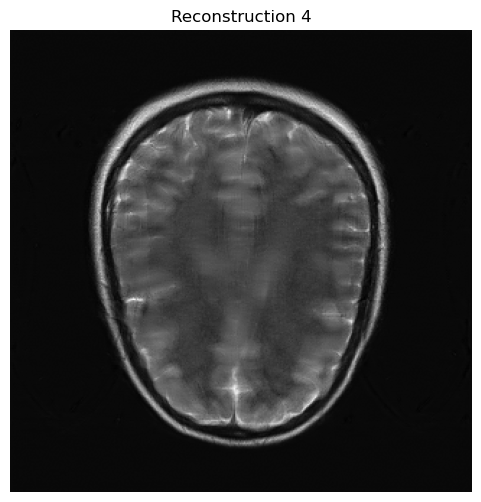

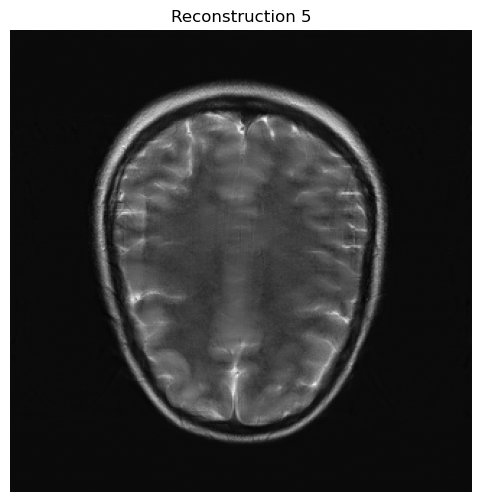

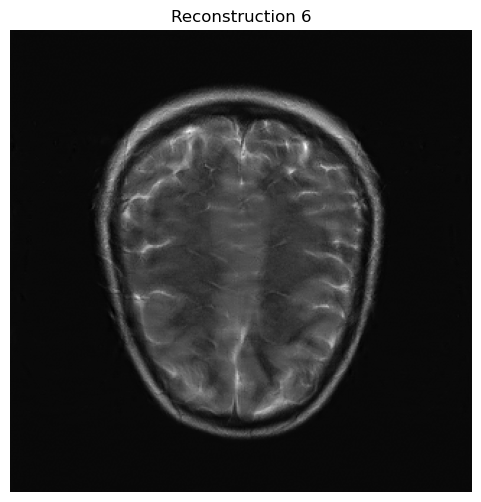

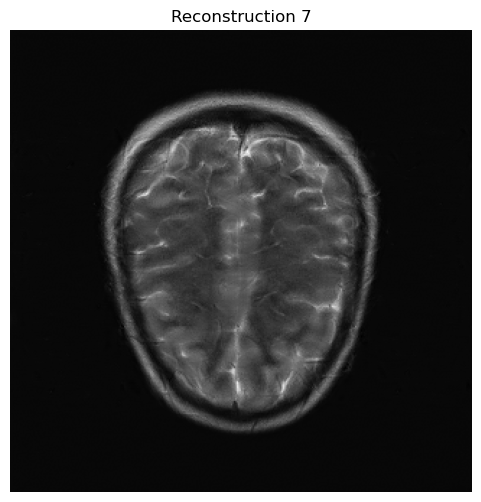

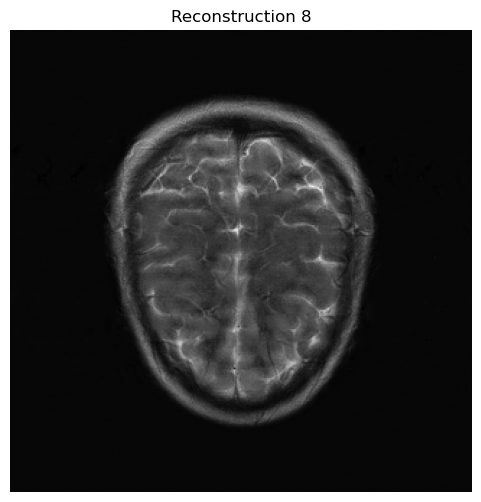

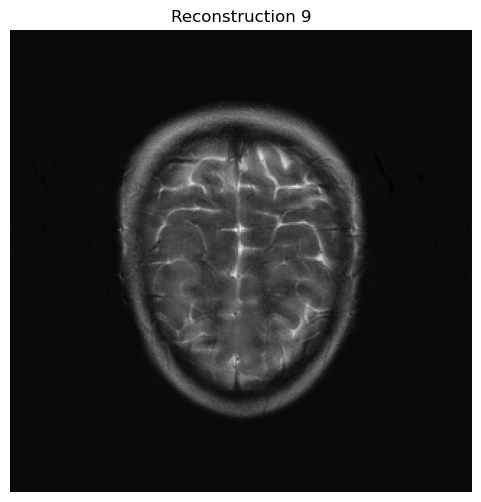

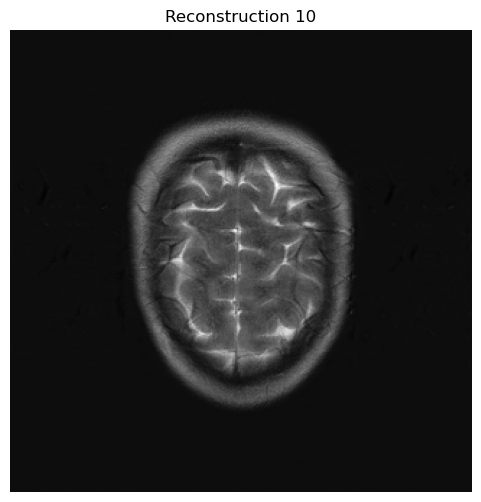

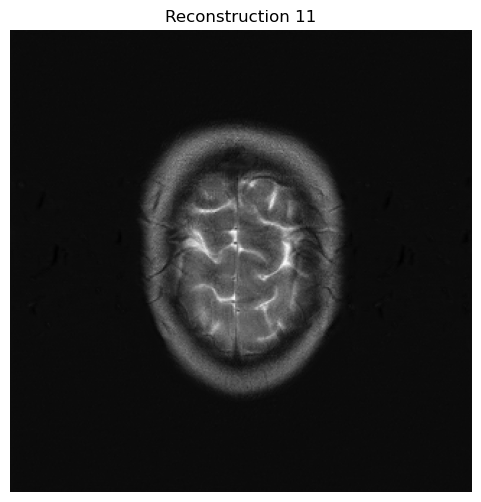

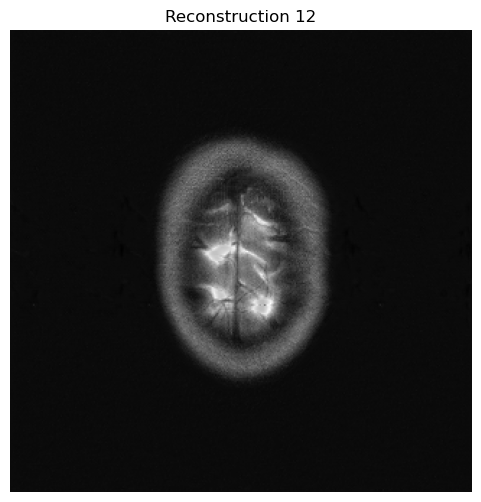

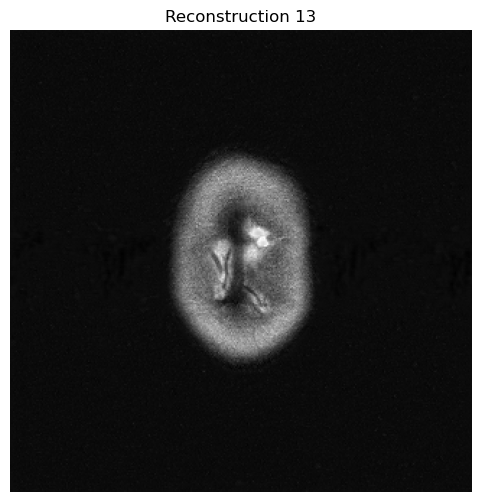

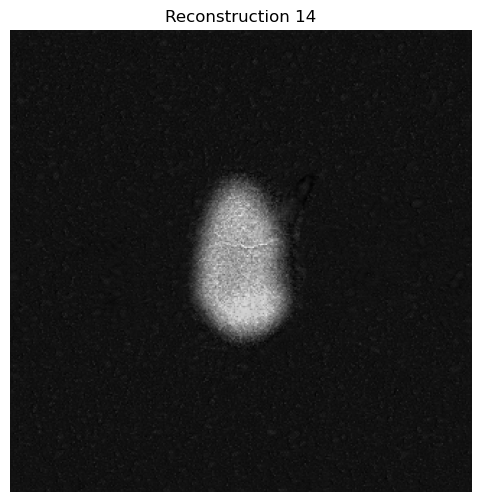

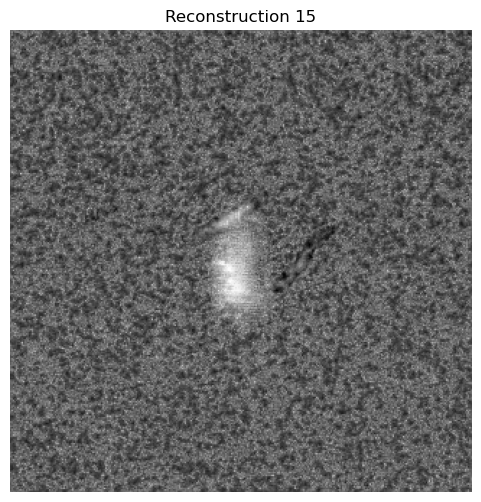

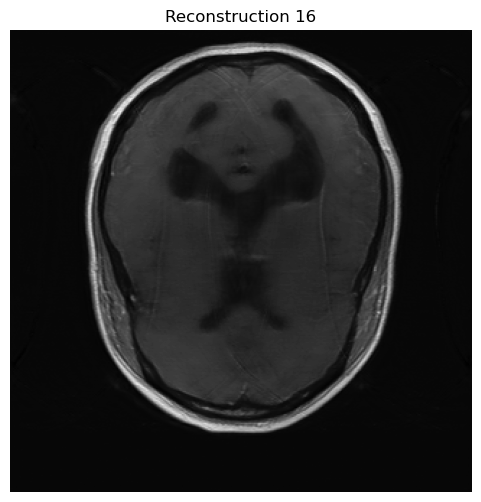

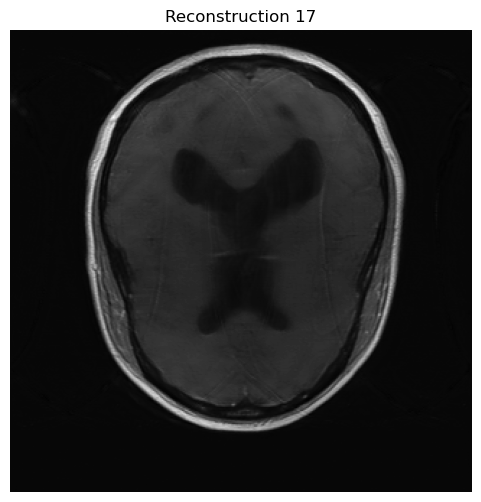

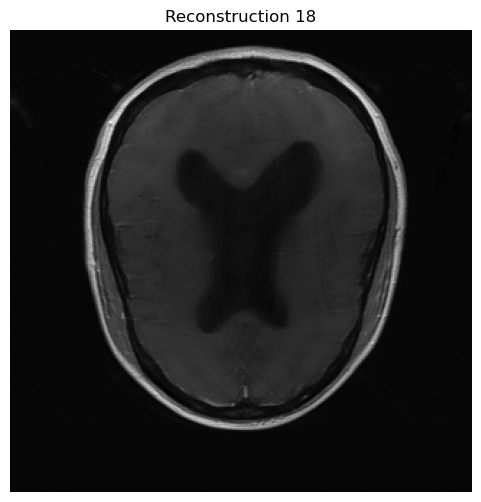

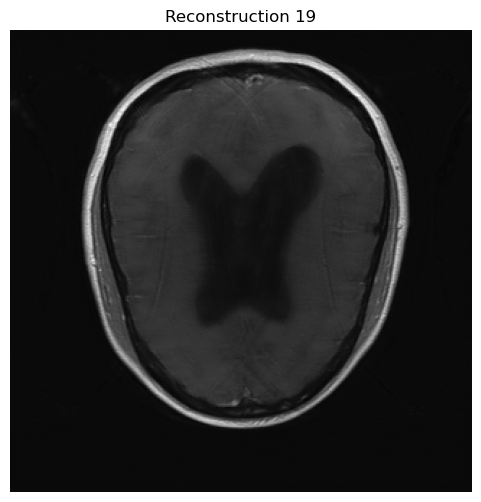

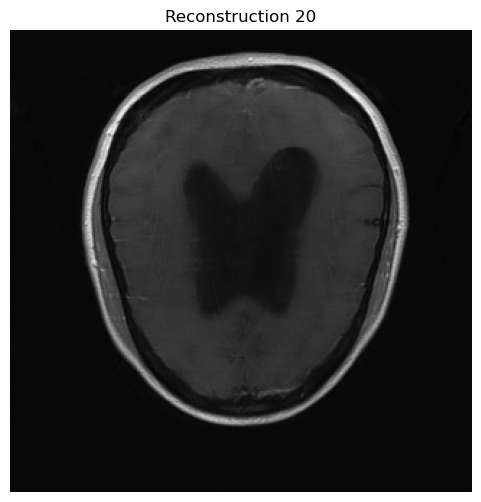

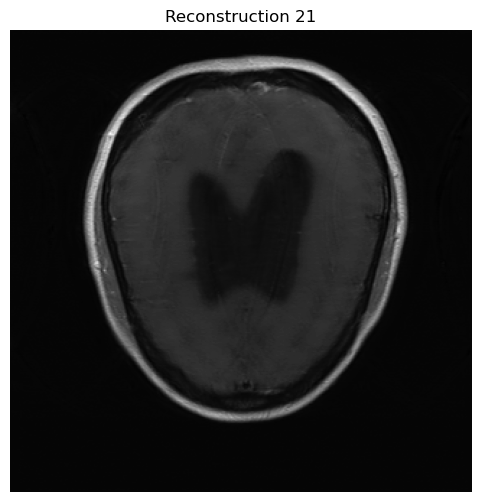

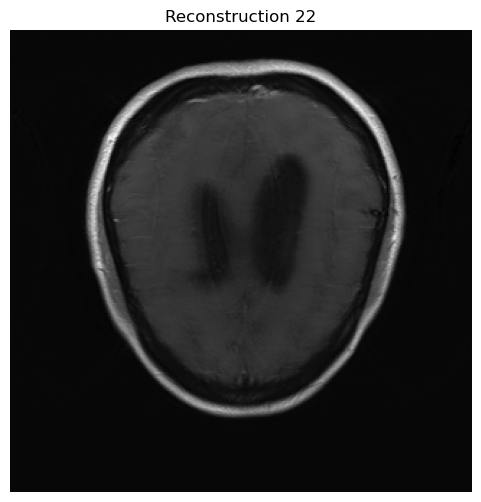

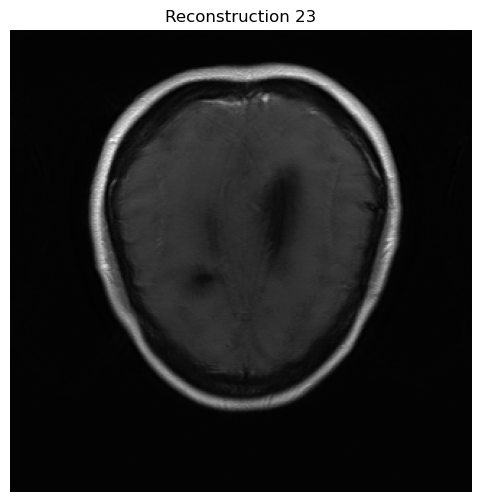

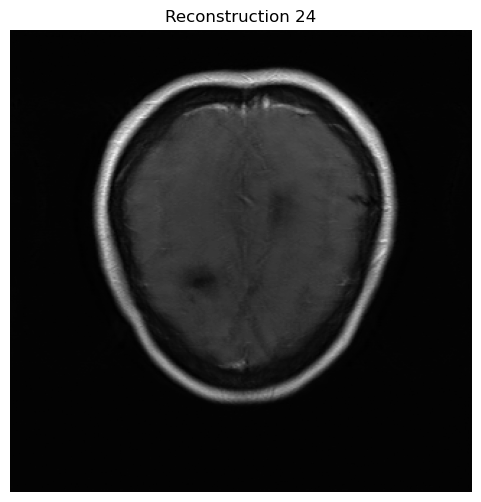

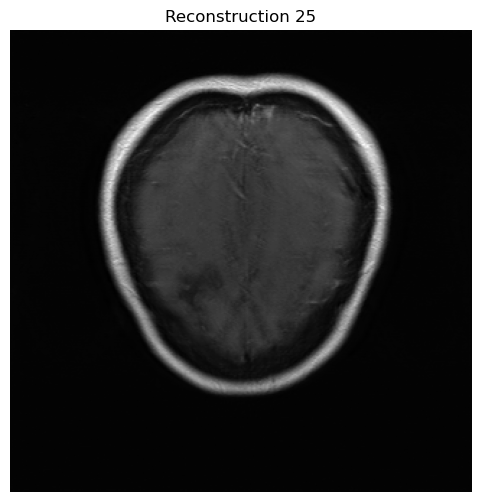

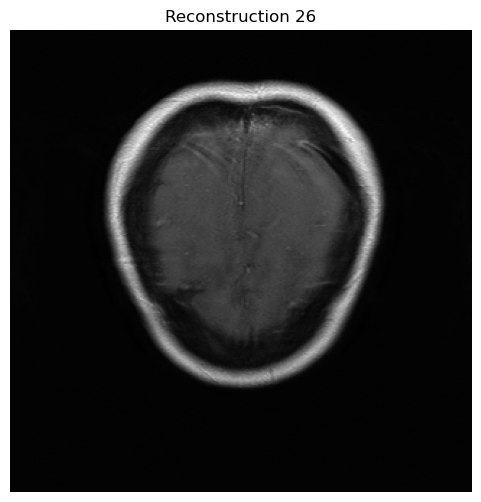

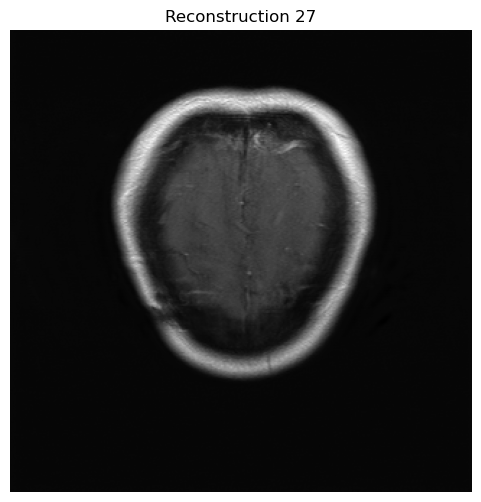

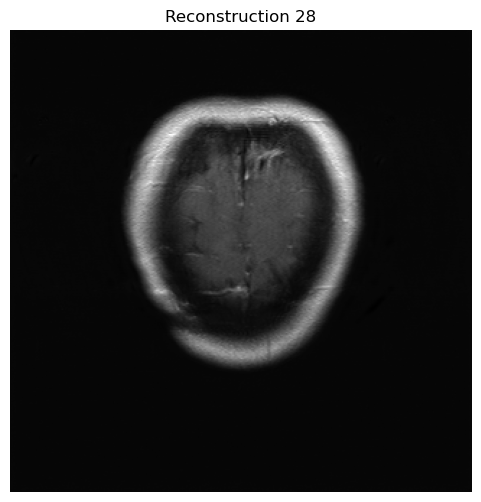

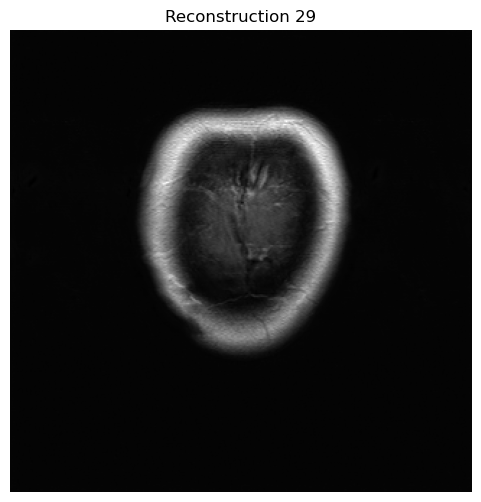

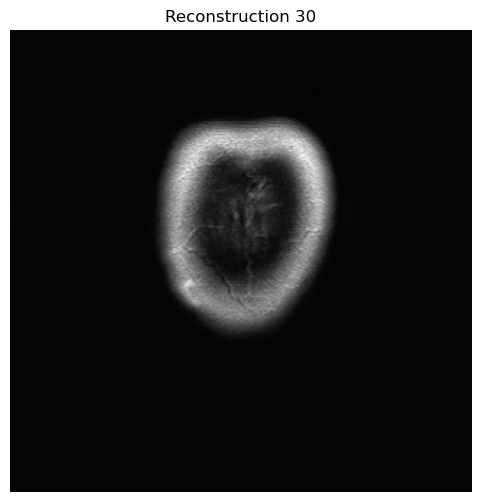

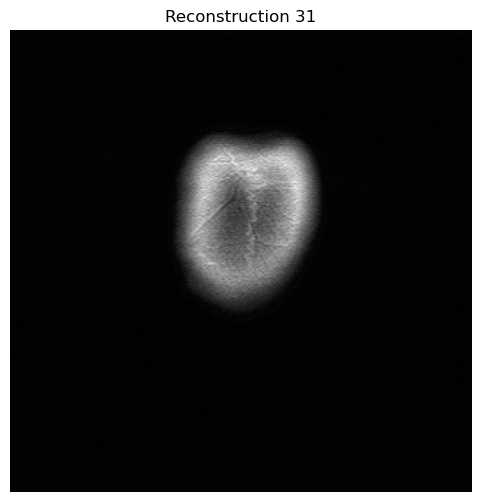

Reconstructions saved to reconstructions


In [18]:
test_dataset = fastmri_dataset(test_config['data_dir'], test_files[-2:], test_config['mask_type'], test_config['center_fractions'], test_config['accelerations'])
test_loader = DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False)


# Example usage
inference(
    model=model,
    test_loader=test_loader,
    device=device,
    output_dir="reconstructions",
    visualize=True  # Set to True to visualize; False to only save
)


In [11]:
def inference(model, test_loader, device, output_dir="reconstructions", visualize=False):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        slice_idx = 0  # Global slice counter
        for inputs, _ in test_loader:  # Targets are optional during inference
            inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
            outputs = model(inputs)

            # Post-process outputs (remove channel dim, convert to numpy)
            reconstructions = outputs.squeeze(1).cpu().numpy()

            # Save each slice
            for recon in reconstructions:
                output_path = os.path.join(output_dir, f"slice_{slice_idx}.npy")
                np.save(output_path, recon)
                slice_idx += 1

                # Optional: Visualize the reconstruction
                if visualize:
                    plt.figure(figsize=(6, 6))
                    plt.imshow(recon, cmap="gray")
                    plt.title(f"Slice {slice_idx}")
                    plt.axis("off")
                    plt.show()

    print(f"All reconstructions saved to {output_dir}")


/tmp/ipykernel_2119237/2860595948.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(undersampled_image_rss, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


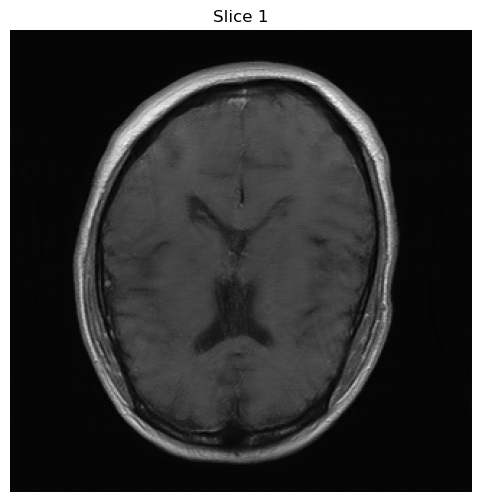

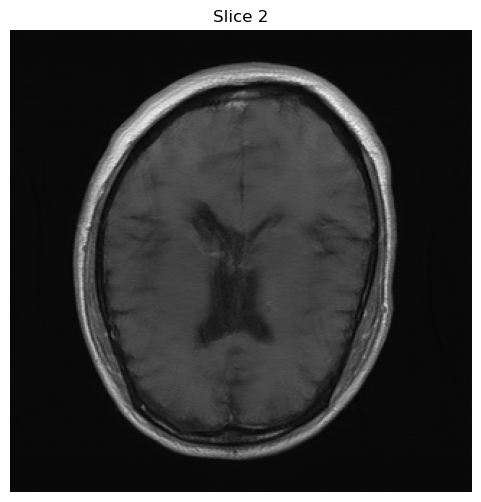

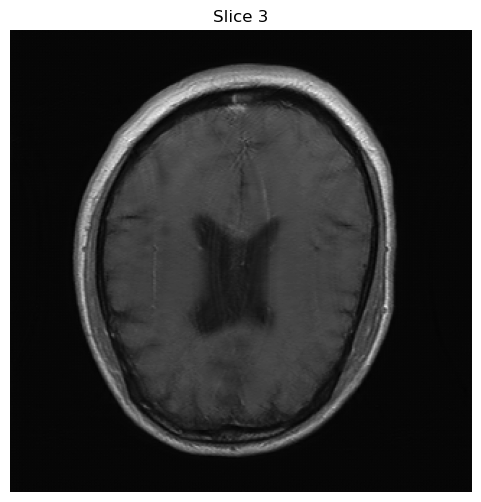

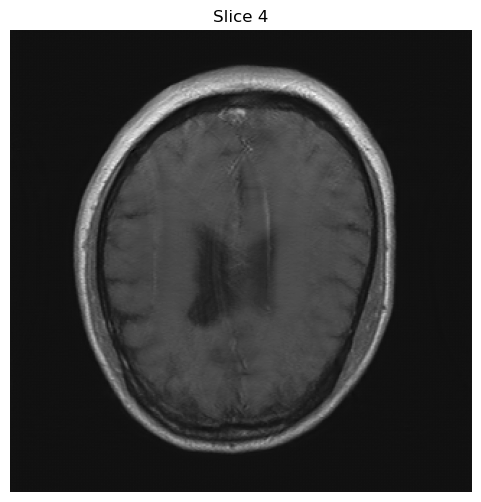

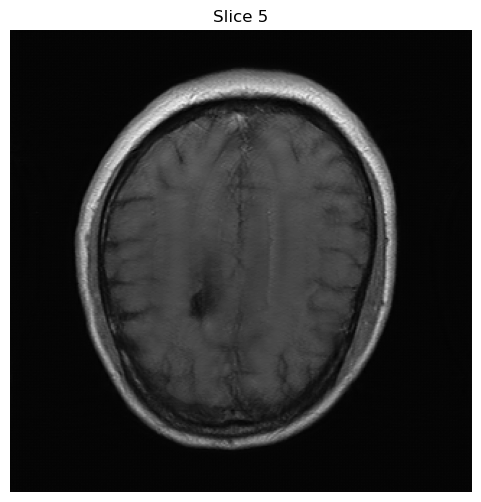

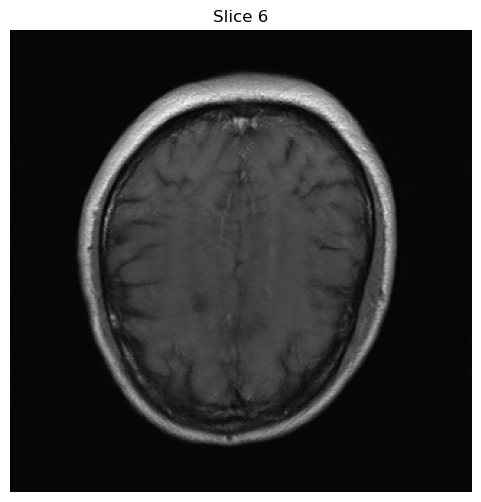

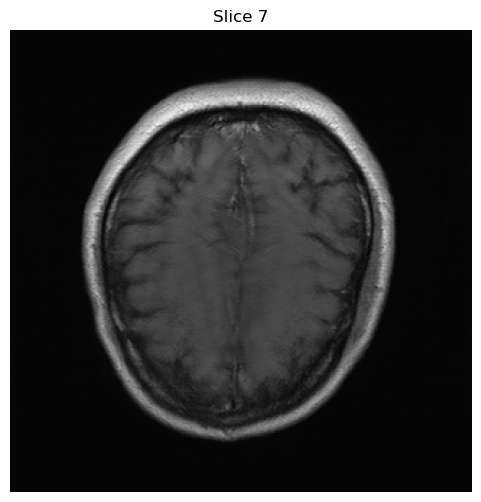

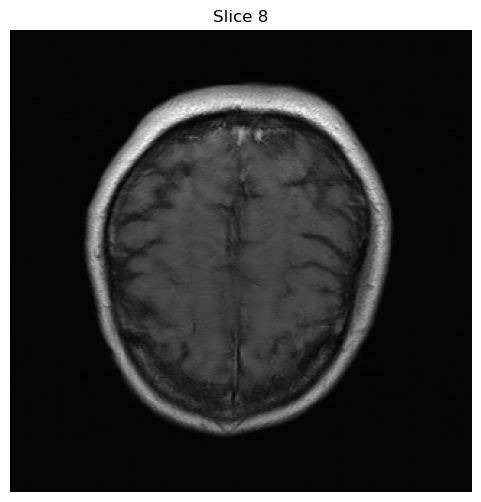

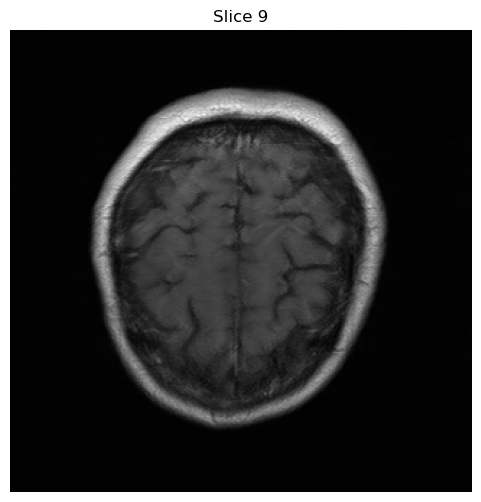

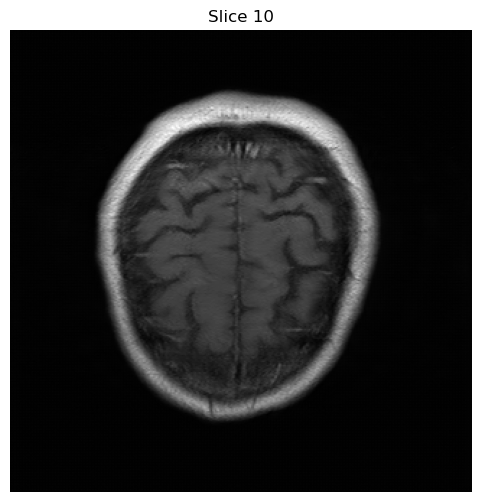

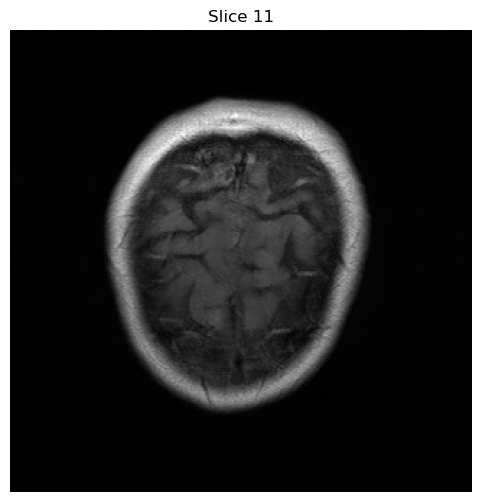

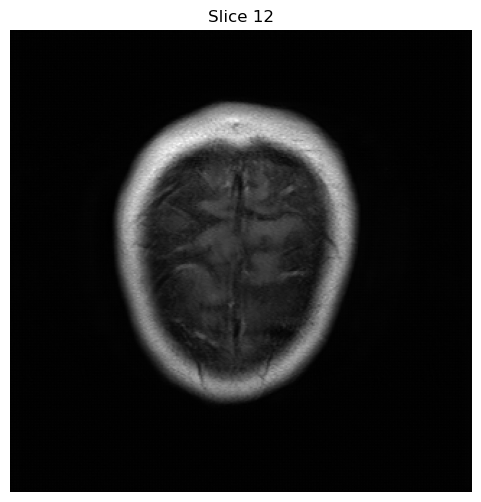

All reconstructions saved to reconstructions


In [13]:
inference(
    model=model,
    test_loader=test_loader,
    device=device,
    output_dir="reconstructions",
    visualize=True
)

/tmp/ipykernel_2104151/2860595948.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(undersampled_image_rss, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


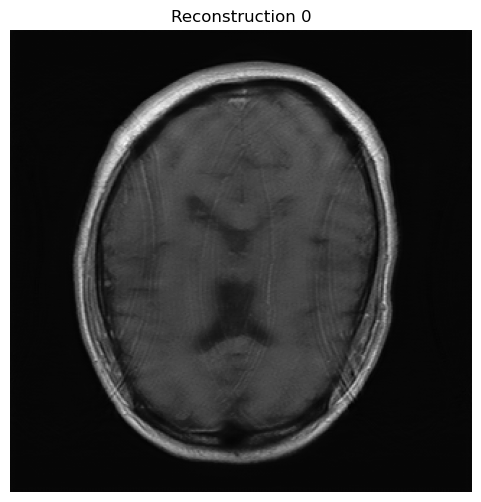

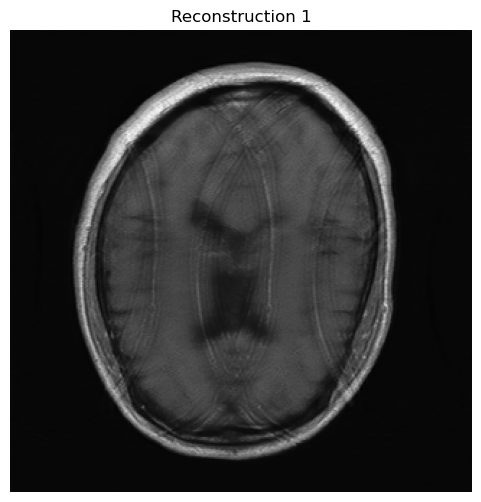

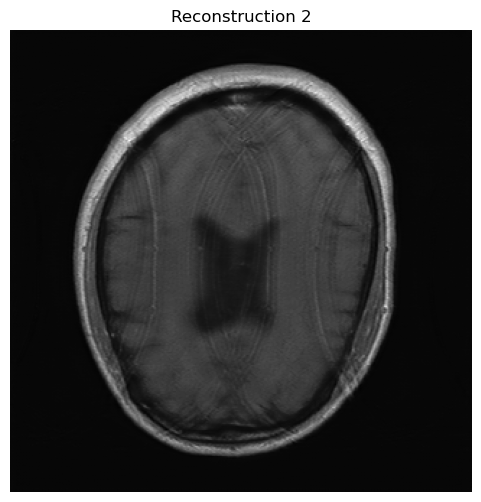

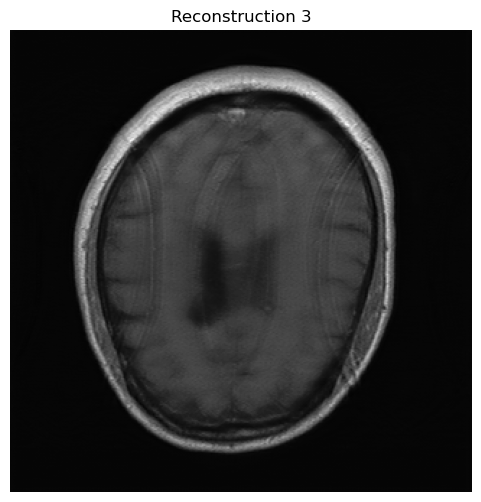

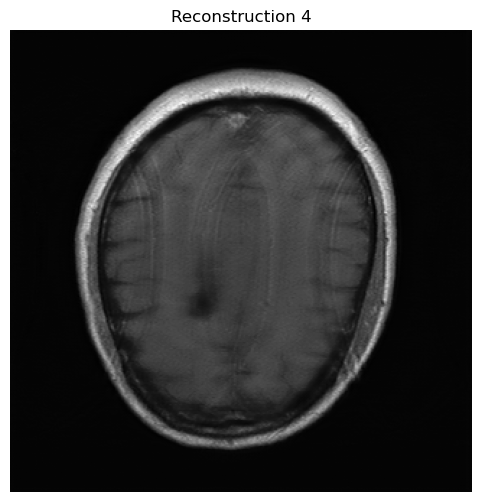

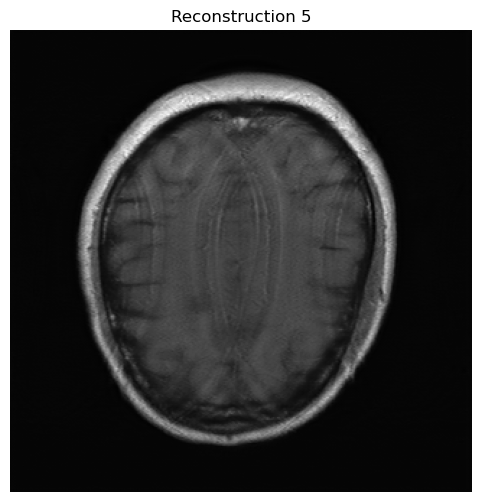

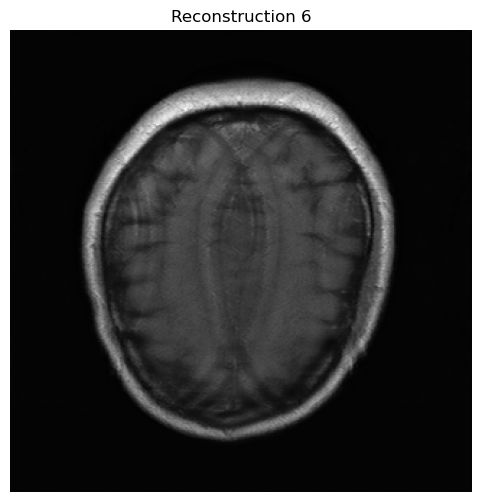

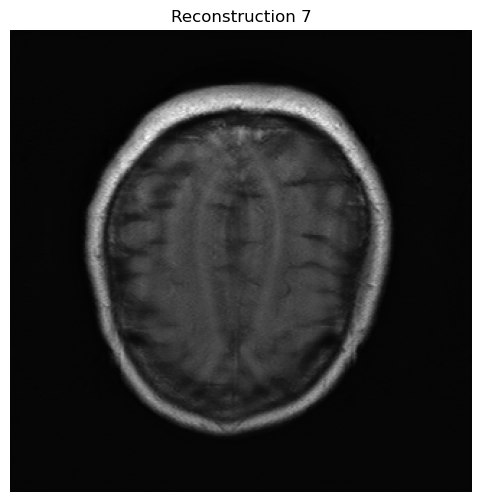

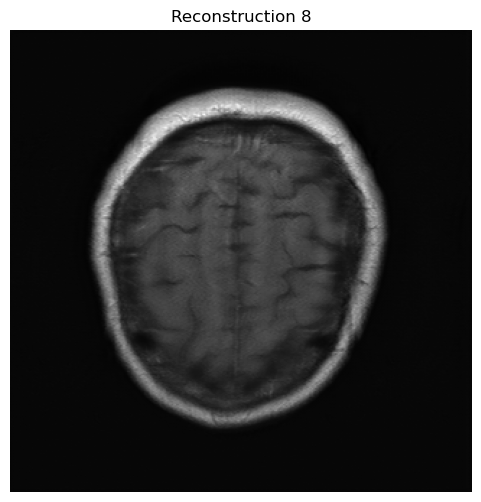

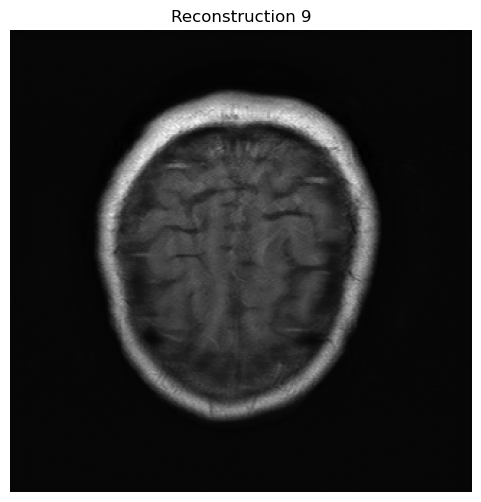

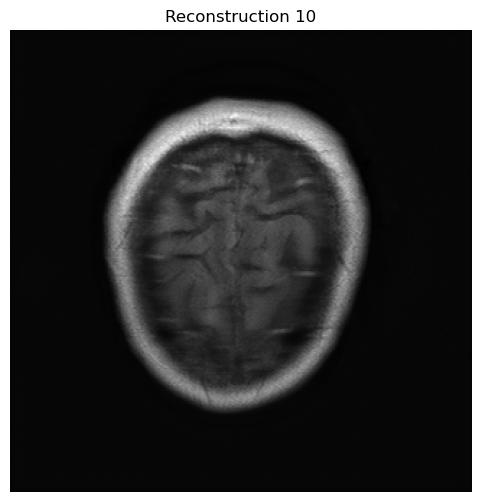

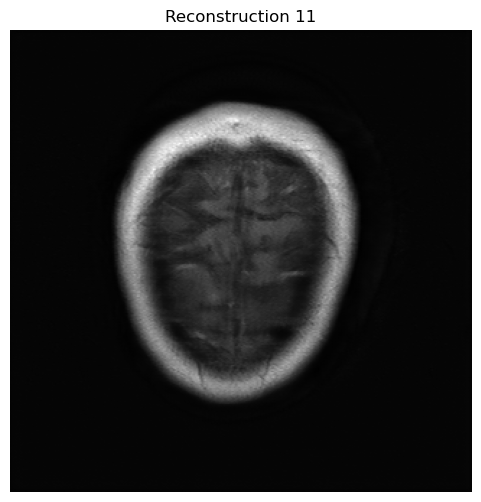

Reconstructions saved to reconstructions


In [10]:
#fastmri unet model 64 chans

test_dataset = fastmri_dataset(data_dir, data_list[460:], mask_type, center_fractions, accelerations)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Example usage
inference(
    model=model,
    test_loader=test_loader,
    device=device,
    output_dir="reconstructions",
    visualize=True  # Set to True to visualize; False to only save
)
